# Baseline analysis for predicting next day's Covid-19 cases from prior 30

In [1]:
import os
import importlib
import random
from collections import defaultdict
import math

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import dsci592.model as model

In [2]:
importlib.reload(model)

<module 'dsci592.model' from '/home/noah/projects/drexel/dsci592/DS-capstone-pt1/code/src/dsci592/model.py'>

In [3]:
pd.set_option("display.max_columns", None)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')
# with tf.device('/gpu:1'):  # using other GPU for another task
    # df = model.load_dataset(golden_dataset_file_name)

df = model.load_dataset(golden_dataset_file_name)


2022-02-28 19:10:21.959058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:10:21.959909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:10:22.018490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:10:22.018750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:10:22.018980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [8]:
def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds()
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)
    

## Baseline 1: Guess zero every time

In [20]:
for name, ds in get_new_loop():
    sum = count = 0
    for _, y in ds:
        y_ = y.numpy().flatten()
        sum += y_.sum()
        count += y_.shape[0]
    print(f'{name}: {sum/count}')


train: 1738.2500355774011
validate: 1754.9772079984493
test: 1739.3318410911274


## Baseline 2: Guess the 30th date every time

In [51]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,-1:,:1].flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 9.785121290955985
validate: 9.549475865976769
test: 9.840210704599464


## Baseline 3: Guess the mean of the 30 days every time

In [63]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 121.31485035080716
validate: 120.17304839525893
test: 120.88257879796626


## Baseline 4: Linear regression

In [116]:
for name, ds in get_new_loop():
    errors = count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_date = np.array([days + 1]).reshape(-1,1)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            errors += np.abs(y[i] - lr.predict(next_date)[0][0])
            count += 1
    print(f'{name}: {errors[0][0]/count}')


train: [[36.93661786]]
validate: [[36.07154467]]
test: [[36.6260068]]


In [ ]:
z = np.arange(days).reshape(-1,1)
plt.scatter(z, x_[i], color="black", label='Training')
z_ = np.arange(days+1).reshape(-1,1)
plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
plt.scatter(30, y_[i], marker='*', label='Actual')
plt.scatter(30, lr.predict(z_)[-1], marker='+', label='Predicted')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()


# Baseline analysis for predicting next seven day's Covid-19 cases from prior 30

In [6]:
# train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=7)

DAYS_TO_PREDICT=7

def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=DAYS_TO_PREDICT)
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)

In [7]:
class NestedDefaultDict(defaultdict):
    def __init__(self, *args, **kwargs):
        super(NestedDefaultDict, self).__init__(NestedDefaultDict, *args, **kwargs)

    def __repr__(self):
        return repr(dict(self))

summary_results = NestedDefaultDict()

def save_summary_results(baseline, dataset, day, mae, rmse):
    summary_results[baseline][dataset][day]['mae'] = mae
    summary_results[baseline][dataset][day]['rmse'] = rmse
    

## Baseline 1: Guess zero every time

In [8]:
with open('baseline1.csv','w') as file:
    for name, ds in get_new_loop():
        errors = np.zeros(DAYS_TO_PREDICT)
        errors_sq = np.zeros(DAYS_TO_PREDICT)
        count = 0
        for _, y in ds:
            count += y.shape[0]
            y_ = y.numpy().squeeze()
            x_  = np.ones(y_.shape)
            errors += np.sum(np.abs(y_ - x_), axis=0)
            errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
        results = []
        for i in range(DAYS_TO_PREDICT):
            mae = errors[i]/count
            rmse = np.sqrt(errors_sq[i]/count)
            # print(f'{name} mae for day {i}: {mae}')
            print(f'{name},{i},{mae},{rmse}')
            file.write(f'{name},{i},{mae},{rmse}')
            save_summary_results('Baseline 1', name, i, mae, rmse )

train,0,7404.88496353823,31472.878365166045
train,1,7437.692041859127,31569.732347338602
train,2,7471.00723990322,31669.681334941066
train,3,7504.273188332234,31769.242339294877
train,4,7538.233400165812,31872.702208980216
train,5,7572.5701800247025,31978.76036013002
train,6,7607.041395529838,32085.798003346
validate,0,7671.1445177220485,36784.85199742884
validate,1,7709.306031728501,37005.46128101208
validate,2,7748.023796375914,37231.68763346822
validate,3,7786.715311250128,37455.316289733855
validate,4,7826.568943619195,37697.347556323155
validate,5,7866.799227692623,37945.35754049084
validate,6,7907.098727546681,38198.10402259446
test,0,7420.006486887953,26295.96608644127
test,1,7452.162448740944,26398.496256722487
test,2,7484.917689214068,26504.40290692683
test,3,7517.833438682711,26612.016481222585
test,4,7551.51453821417,26723.19296077859
test,5,7586.005092325561,26847.09836388536
test,6,7620.654543586988,26972.44568662165


In [188]:
# OLD VERSION -- SLOW!!!!
# for name, ds in get_new_loop():
#     sums = [0] * DAYS_TO_PREDICT
#     counts = [0] * DAYS_TO_PREDICT
#     for _, ys in ds:
#         for y_days in ys:
#             for i, y in enumerate(y_days):
#                 sums[i] += y
#                 counts[i] += 1
#     for i in range(DAYS_TO_PREDICT):
#         print(f'{name} mae for day {i}: {sums[i]/counts[i]}')


train mae for day 0: [1756.4777]
validate mae for day 0: [1798.8082]
test mae for day 0: [1720.9961]


## Baseline 2: Guess the 30th date every time

In [9]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        count += x_.shape[0]
        y_ = y.numpy().squeeze(-1)
        x_ = x.numpy()[:,-1:,:1]
        x_ = x_.reshape(-1,1)
        x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        errors += np.sum(np.abs(y_ - x_), axis=0)
        errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
    for i in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {i}: {errors[i]/count}')
        mae = errors[i]/count
        rmse = np.sqrt(errors_sq[i]/count)
        print(f'{name} mae for day {i}: {mae}')
        save_summary_results('Baseline 2', name, i, mae, rmse )

train mae for day 0: 32.8429455683335
train mae for day 1: 65.7398259615409
train mae for day 2: 99.11701932265335
train mae for day 3: 132.45343612114812
train mae for day 4: 166.47721680662028
train mae for day 5: 200.88710522462404
train mae for day 6: 235.43198475110944
validate mae for day 0: 37.91970440437481
validate mae for day 1: 76.11719381219825
validate mae for day 2: 114.84567543600355
validate mae for day 3: 153.52804808355503
validate mae for day 4: 193.36982165730615
validate mae for day 5: 233.59019016651888
validate mae for day 6: 273.89247413538277
test mae for day 0: 31.995716381881007
test mae for day 1: 64.18299648159542
test mae for day 2: 96.95985784383332
test mae for day 3: 129.8896080844417
test mae for day 4: 163.57494753948345
test mae for day 5: 198.10712595257255
test mae for day 6: 232.79992426752497


## Baseline 3: Guess the mean of the 30 days every time

In [10]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        y_ = y.numpy().squeeze()
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        x_ = x_.reshape(-1,1)
        x_ = x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        count += y_.shape[0]
        errors += np.sum(np.abs(y_ - x_), axis=0)
        errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
    for i in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {i}: {errors[i]/count}')
        mae = errors[i]/count
        rmse = np.sqrt(errors_sq[i]/count)
        print(f'{name} mae for day {i}: {mae}')
        save_summary_results('Baseline 3', name, i, mae, rmse )

train mae for day 0: 462.49514401599487
train mae for day 1: 495.2954028348815
train mae for day 2: 528.6010278368642
train mae for day 3: 561.8548935491854
train mae for day 4: 595.8009405455307
train mae for day 5: 630.1323670250453
train mae for day 6: 664.5959063487418
validate mae for day 0: 532.3068330208243
validate mae for day 1: 570.4765037042552
validate mae for day 2: 609.201413929809
validate mae for day 3: 647.8992898688152
validate mae for day 4: 687.7588941506492
validate mae for day 5: 727.9950539466366
validate mae for day 6: 768.298935562822
test mae for day 0: 444.395906682452
test mae for day 1: 476.5631786132527
test mae for day 2: 509.32837299718767
test mae for day 3: 542.2528963509226
test mae for day 4: 575.9422284424502
test mae for day 5: 610.4795938040932
test mae for day 6: 645.17408522709


## Baseline 4: Linear regression

In [ ]:
# SLOW
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().squeeze()  
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_dates = np.arange(days +1, days + 1 + DAYS_TO_PREDICT)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            for j in range(DAYS_TO_PREDICT):
                errors[j] += np.abs(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0])
                errors_sq[j] += np.power(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0],2)
        count += y_.shape[0]
    for k in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {k}: {errors[k]/count}')
        mae = errors[k]/count
        rmse = np.sqrt(errors_sq[k]/count)
        print(f'{name} mae for day {k}: {mae}')
        save_summary_results('Baseline 4', name, k, mae, rmse )

In [11]:
# linear regression with sampling
for (name, ds), batches in zip(get_new_loop(), [1244, 266, 266]):
    samples = random.sample(range(batches), int(batches*0.10))
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    lr = LinearRegression()
    for l, (x, y) in enumerate(ds):
        if l not in samples:
            continue
        y_ = y.numpy().squeeze()  
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_dates = np.arange(days, days + DAYS_TO_PREDICT)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            for j in range(DAYS_TO_PREDICT):
                errors[j] += np.abs(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0])
                errors_sq[j] += np.power(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0],2)
        count += y_.shape[0]
    for k in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {k}: {errors[k]/count}')
        mae = errors[k]/count
        rmse = np.sqrt(errors_sq[k]/count)
        print(f'{name} mae for day {k}: {mae}')
        save_summary_results('Baseline 4', name, k, mae, rmse )

train mae for day 0: 97.15781471459863
train mae for day 1: 113.7667740411459
train mae for day 2: 131.01529871580124
train mae for day 3: 148.64237426448483
train mae for day 4: 167.28808143280506
train mae for day 5: 186.83568268693898
train mae for day 6: 207.0493836704892
validate mae for day 0: 74.78185427135678
validate mae for day 1: 87.67695477386934
validate mae for day 2: 100.69304522613065
validate mae for day 3: 114.02956783919598
validate mae for day 4: 128.5896381909548
validate mae for day 5: 143.52888442211056
validate mae for day 6: 158.85883417085427
test mae for day 0: 97.92545419404716
test mae for day 1: 114.75680324700426
test mae for day 2: 132.9558851952068
test mae for day 3: 151.3772419791264
test mae for day 4: 170.9658484731349
test mae for day 5: 192.266814843448
test mae for day 6: 214.36963664476227


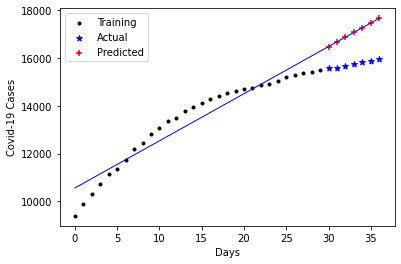

In [12]:
days = x_.shape[1]
z = np.arange(days).reshape(-1,1)
training = plt.scatter(z, x_[i], color="black", marker='.', label='Training')
z_ = np.arange(days+DAYS_TO_PREDICT).reshape(-1,1)

plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
for j in range(DAYS_TO_PREDICT):
    actual = plt.scatter(30+j, y_[i][j], marker='*', label='Actual', color='blue')
    prediction = plt.scatter(30 + j, lr.predict(z_)[30+j], marker='+', label='Predicted', color='red')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend([training, actual, prediction], ['Training', 'Actual', 'Predicted'])
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()

In [13]:
df = pd.DataFrame(summary_results)
df = df.T
df

,train,validate,test
Baseline 1,"{0: {'mae': 7404.88496353823, 'rmse': 31472.87...","{0: {'mae': 7671.1445177220485, 'rmse': 36784....","{0: {'mae': 7420.006486887953, 'rmse': 26295.9..."
Baseline 2,"{0: {'mae': 32.8429455683335, 'rmse': 289.0405...","{0: {'mae': 37.91970440437481, 'rmse': 401.553...","{0: {'mae': 31.995716381881007, 'rmse': 302.53..."
Baseline 3,"{0: {'mae': 462.49514401599487, 'rmse': 1946.0...","{0: {'mae': 532.3068330208243, 'rmse': 3812.58...","{0: {'mae': 444.395906682452, 'rmse': 1942.017..."
Baseline 4,"{0: {'mae': 97.15781471459863, 'rmse': 581.505...","{0: {'mae': 74.78185427135678, 'rmse': 297.924...","{0: {'mae': 97.92545419404716, 'rmse': 642.633..."


In [16]:
list(summary_results.keys())

['Baseline 1', 'Baseline 2', 'Baseline 3', 'Baseline 4']

In [17]:
baselines_mae = [[] for i in range(4)]
baselines_rmse = [[] for i in range(4)]
for i, baseline in enumerate(summary_results.values()):
    for _, days in baseline.items():
        mae = {}
        rmse = {}
        for k, v in days.items():
            mae[k] = v['mae']
            rmse[k] = v['rmse']
        baselines_mae[i].append(mae)
        baselines_rmse[i].append(rmse)


In [18]:
mae_df = pd.DataFrame({'Baseline 1': baselines_mae[0][2], 'Baseline 2': baselines_mae[1][2], 'Baseline 3': baselines_mae[2][2], 'Baseline 4': baselines_mae[3][2]}).T
mae_df.columns = ([i for i in range(1,8)])
mae_df

,1,2,3,4,5,6,7
Baseline 1,7420.006487,7452.162449,7484.917689,7517.833439,7551.514538,7586.005092,7620.654544
Baseline 2,31.995716,64.182996,96.959858,129.889608,163.574948,198.107126,232.799924
Baseline 3,444.395907,476.563179,509.328373,542.252896,575.942228,610.479594,645.174085
Baseline 4,97.925454,114.756803,132.955885,151.377242,170.965848,192.266815,214.369637


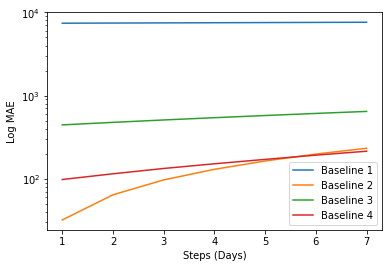

In [19]:
ax = mae_df.T.plot(kind='line',
                 # title='Mean Absolute Loss (Validation Set)',
                 logy=True,
                 xlabel='Steps (Days)',
                 ylabel='Log MAE')
fig = ax.get_figure()
fig.savefig('mae_validation.png')

In [20]:
rmse_df = pd.DataFrame({'Baseline 1': baselines_rmse[0][2], 'Baseline 2': baselines_rmse[1][2], 'Baseline 3': baselines_rmse[2][2], 'Baseline 4': baselines_rmse[3][2]}).T
rmse_df.columns = ([i for i in range(1,8)])
rmse_df

,1,2,3,4,5,6,7
Baseline 1,26295.966086,26398.496257,26504.402907,26612.016481,26723.192961,26847.098364,26972.445687
Baseline 2,302.536934,470.624211,632.921437,789.466131,948.476749,1133.668605,1316.425357
Baseline 3,1942.017632,2089.197525,2240.459369,2390.455388,2545.323085,2725.077279,2903.946220
Baseline 4,642.633068,738.872518,838.658144,935.909669,1036.623849,1152.735478,1271.288858


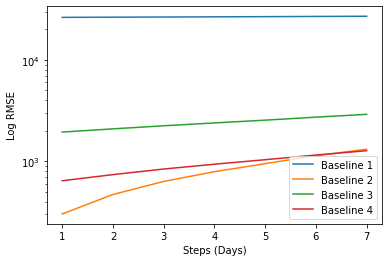

In [21]:
ax = rmse_df.T.plot(kind='line',
                 # title='Root Mean Square Loss (Validation Set)',
                 logy=True,
                 xlabel='Steps (Days)',
                 ylabel='Log RMSE')
fig = ax.get_figure()
fig.savefig('rmse_validation.png')

In [197]:
both_df = pd.DataFrame({'Baseline 1': {'mse': 1, 'rmse': baselines_rmse[0][2]}, 'Baseline 2': baselines_rmse[1][2], 'Baseline 3': baselines_rmse[2][2], 'Baseline 4': baselines_rmse[3][2]}).T
# both_df.columns = ([i for i in range(1,8)])
both_df

,mse,rmse,0,1,2,3,4,5,6
Baseline 1,1,"{0: 25747.03486813846, 1: 25857.53159076635, 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baseline 2,NaN,NaN,288.227048,469.957367,643.21965,804.178475,975.87662,1168.78451,1358.812619
Baseline 3,NaN,NaN,1989.854307,2144.333389,2303.820253,2459.154202,2623.281517,2809.449287,2994.362205
Baseline 4,NaN,NaN,903.048098,1080.662202,1276.744465,1462.506419,1658.234656,1985.663126,2307.226328


In [198]:
sr = {}
for k,v in summary_results.items():
    for k_, v_ in v.items():
        if k_ == 'test':
            sr[k] = v_



combined_df = pd.DataFrame.from_dict({(i,j): sr[i][j] 
                           for i in sr.keys() 
                           for j in sr[i].keys()},
                       orient='index')
combined_df.columns = ['MAE', 'RMSE']
combined_df

MAE          RMSE    
Baseline 1 0  7290.052478  25747.034868
           1  7322.190589  25857.531591
           2  7354.994960  25972.493580
           3  7387.805210  26086.957315
           4  7421.379804  26207.090798
           5  7455.775214  26339.562432
           6  7490.349461  26473.555333
Baseline 2 0    32.002339    288.227048
           1    64.206147    469.957367
           2    97.051148    643.219650
           3   129.907325    804.178475
           4   163.540894    975.876620
           5   197.983226   1168.784510
           6   232.623025   1358.812619
Baseline 3 0   449.128383   1989.854307
           1   481.297429   2144.333389
           2   514.131535   2303.820253
           3   546.969945   2459.154202
           4   580.571591   2623.281517
           5   614.993736   2809.449287
           6   649.594455   2994.362205
Baseline 4 0   113.090974    903.048098
           1   134.149932   1080.662202
           2   156.651604   1276.744465
           3   179.542965   1462.506419
           4   203.992230   1658.234656
           5   232.448183   1985.663126
           6   261.718090   2307.226328

In [199]:
sr = {}
for k,v in summary_results.items():
    for k_, v_ in v.items():
        if k_ == 'test':
            sr[k] = v_



combined_df = pd.DataFrame.from_dict({(i,j): sr[i][j] 
                           for i in sr.keys() 
                           for j in sr[i].keys()},
                       orient='index')
combined_df.columns = ['MAE', 'RMSE']
combined_df

{'Baseline 1': {0: {'mae': 7290.052477530079, 'rmse': 25747.03486813846}, 1: {'mae': 7322.190589378678, 'rmse': 25857.53159076635}, 2: {'mae': 7354.994959806529, 'rmse': 25972.49357974198}, 3: {'mae': 7387.8052104600965, 'rmse': 26086.957314706986}, 4: {'mae': 7421.379803816684, 'rmse': 26207.090798477326}, 5: {'mae': 7455.7752141517185, 'rmse': 26339.562432454593}, 6: {'mae': 7490.349460947918, 'rmse': 26473.555333473396}},
 'Baseline 2': {0: {'mae': 32.00233928262, 'rmse': 288.22704839849234}, 1: {'mae': 64.20614692653673, 'rmse': 469.9573670070359}, 2: {'mae': 97.0511477929377, 'rmse': 643.2196499848361}, 3: {'mae': 129.90732523185645, 'rmse': 804.1784748611365}, 4: {'mae': 163.54089412580143, 'rmse': 975.8766200110147}, 5: {'mae': 197.9832257238215, 'rmse': 1168.78451026302}, 6: {'mae': 232.62302517083168, 'rmse': 1358.8126194109154}},
 'Baseline 3': {0: {'mae': 449.1283827871423, 'rmse': 1989.8543070995056}, 1: {'mae': 481.2974285033452, 'rmse': 2144.3333888682196}, 2: {'mae': 514

In [24]:
sr = {}
for k,v in summary_results.items():
    for k_, v_ in v.items():
        if k_ == 'test':
            sr[k] = v_
            
sr2 = defaultdict(dict)
for bl, days in sr.items():
    for day, values in days.items():
        for typ, value in values.items():
            sr2[(f'Step {day}', typ.upper())][bl] = value
sr2




combined_df = pd.DataFrame.from_dict(sr2)
pd.set_option('display.colheader_justify', 'center')
print(combined_df.style.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrr}
 & \multicolumn{2}{r}{Step 0} & \multicolumn{2}{r}{Step 1} & \multicolumn{2}{r}{Step 2} & \multicolumn{2}{r}{Step 3} & \multicolumn{2}{r}{Step 4} & \multicolumn{2}{r}{Step 5} & \multicolumn{2}{r}{Step 6} \\
 & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE \\
Baseline 3 & 444.395907 & 1942.017632 & 476.563179 & 2089.197525 & 509.328373 & 2240.459369 & 542.252896 & 2390.455388 & 575.942228 & 2545.323085 & 610.479594 & 2725.077279 & 645.174085 & 2903.946220 \\
Baseline 4 & 97.925454 & 642.633068 & 114.756803 & 738.872518 & 132.955885 & 838.658144 & 151.377242 & 935.909669 & 170.965848 & 1036.623849 & 192.266815 & 1152.735478 & 214.369637 & 1271.288858 \\
Baseline 1 & 7420.006487 & 26295.966086 & 7452.162449 & 26398.496257 & 7484.917689 & 26504.402907 & 7517.833439 & 26612.016481 & 7551.514538 & 26723.192961 & 7586.005092 & 26847.098364 & 7620.654544 & 26972.445687 \\
Baseline 2 & 31.995716 & 302.536934 & 64.182996